In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, \
precision_score, auc, plot_confusion_matrix, classification_report, matthews_corrcoef
from imblearn.over_sampling import SMOTE
import shap
import lightgbm as lgb
%matplotlib inline

In [3]:
data = pd.read_csv('datasets/final_elem+hard-feat_data_cls_com.csv')
X = data.iloc[:,1:-1]
Y = data.iloc[:,-1]

In [4]:
def read_param():
    f0 = open('datasets/best-paramters_et_optuna_TPE.txt','r')
    b = []
    for line in f0.readlines():
        a = line.split()
        a_ = [a[i] for i in range(len(a))]
        b.append(a_)
    f0.close()
    p1 = int(b[1][1]); p2 = int(b[2][1]); p3 = int(b[3][1]); p4 = int(b[4][1])
    p5 = float(b[5][1]); p6 = int(b[6][1])
    return p1, p2, p3, p4, p5, p6

target_names = ['Hh', 'Hm', 'Hl', 'Mh', 'Mm', 'Ml', 'Lh', 'Lm', 'Ll']

random = 129
random_sm = 0
test_size = 0.1
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, random_state = random, stratify = Y)
dict = {2:100, 6:100}
oversample = SMOTE(sampling_strategy = dict, random_state = random_sm)
x_train_sm, y_train_sm = oversample.fit_resample(X_train, Y_train)

p1, p2, p3, p4, p5, p6 = read_param()
weights = {0:3.0, 1:1.0, 2:3.0, 3:3.0, 4:0.8, 5:1.0, 6:3.0, 7:1.6, 8:1.9} # --> best one till now
#weights = "balanced"
params = {"class_weight": weights, "n_estimators": p1, "max_depth": p2, "criterion": "entropy",
          'min_samples_leaf': p3, 'min_samples_split': p4, 'min_weight_fraction_leaf': p5, "random_state": p6 
          }
et = ExtraTreesClassifier(**params)
et.fit(x_train_sm, y_train_sm)

Y_pred_test = et.predict(X_test)
Y_pred_train = et.predict(x_train_sm)

## SHAP plots

In [5]:
explainerModel = shap.TreeExplainer(model = et)
shap_values = explainerModel.shap_values(X)

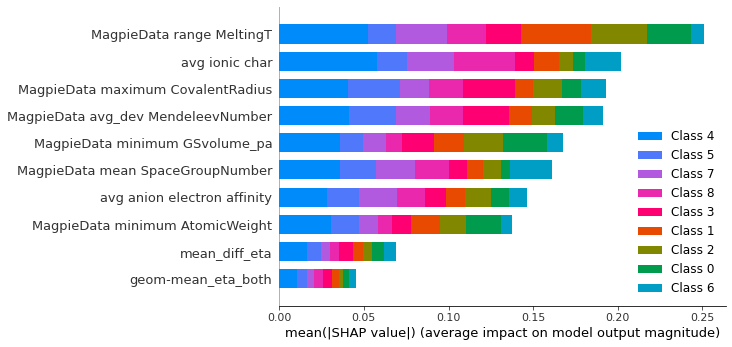

In [6]:
## 1. SHAP Feature importance (Global interpretability)
shap.summary_plot(shap_values, X)
# plt.savefig('shap_feature-importance.png', bbox_inches='tight', dpi=300)

In [8]:
comp = data['Compound']
print(comp.iloc[169], Y[169])
print(comp.iloc[214], Y[214])

CN-CN-Ba 4
NC-NC-Ba 3


## SHAP multioutput decision plot

In [9]:
## Local interpretability
idx =  169 ## 169 or 214
instance = X.iloc[idx][None, :]
pred = et.predict(instance)
print(Y.iloc[169], pred)

4 [4]


In [10]:
def class_labels(classifier, instance, class_names=None):
    """
    Creates a set of legend labels based on the decision
    scores of a classifier and, optionally, the class names.
    """

    decision_scores = classifier.decision_function(instance)

    if not class_names:
        class_names = [f'Class {i}' for i in range(decision_scores.shape[1])]

    for i, score in enumerate(np.nditer(decision_scores)):
        class_names[i] = class_names[i] + ' ({})'.format(round(score.item(),3))

    return class_names

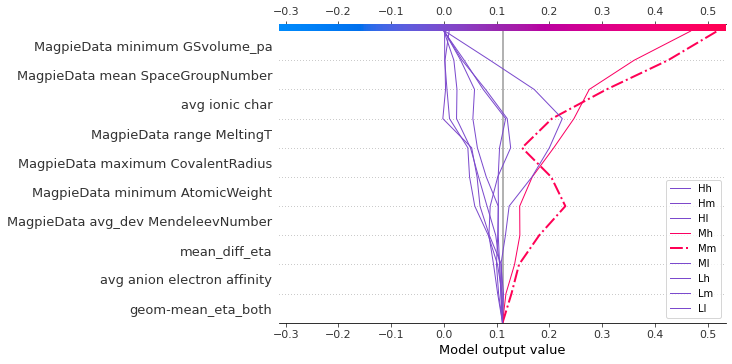

In [11]:
# legend_labels = class_labels(et, instance)

instance_shap = np.array(shap_values)[:, idx, :]
feature_order = np.argsort(np.sum(np.abs(instance_shap),axis=0))[::-1]
feat_importance = [X.columns[i] for i in feature_order]

r = shap.multioutput_decision_plot(explainerModel.expected_value.tolist(),
                               shap_values,
                               idx,
                               feature_names=feat_importance,
#                                feature_order=r.feature_idx,
                               feature_order='importance',
                               highlight=[pred.item()],
                               legend_labels=target_names,
                               legend_location='lower right',
#                                xlim=r.xlim,
                               return_objects=False)
# plt.savefig('shap_multiout_169.png', dpi=300)    ## change the name also